In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from PIL import Image
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import numpy as np
from matplotlib.widgets import Slider, Button
# plt.style.use('./deeplearning.mplstyle')

def compute_entropy(y):

    entropy = 0
    # p1 is the fraction which is actually true meaning 1
    if len(y) == 0:
        return 0
    entropy = sum(y[y==1])/len(y)
    if entropy == 0 or entropy == 1:
        return 0
    else:
        return -entropy*np.log2(entropy) - (1-entropy)*np.log2(1-entropy)


def split_dataset(X, node_indices, feature):

    left_indices = []
    right_indices = []
    # here features would mean the one we want for example the start has for example ear shape then the ones having the type which we want would then be
    # come in the lft indices and the ones which is zero would go the right \
    for i in node_indices:
        if X[i][feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)

    return left_indices, right_indices



def compute_information_gain(X, y, node_indices, feature):

    left_indices, right_indices = split_dataset(X, node_indices, feature)
    # X is the dataset
    # y is the classes
    # node_indices is the indices of the current node
    # feature is the feature we want to split on

    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]
    # left and right trees then divide
    information_gain = 0

    node_entropy = compute_entropy(y_node)
    left_entropy = compute_entropy(y_left)
    right_entropy = compute_entropy(y_right)

    # we find the weights for the weighted average

    w_left = len(X_left) / len(X_node)
    w_right = len(X_right) / len(X_node)
    # here the weighted entropy is then calculated
    weighted_entropy = w_left * left_entropy + w_right * right_entropy
    information_gain = node_entropy - weighted_entropy

    return information_gain

# the best split then is the one in which the info gain is the maximum
def get_best_split(X, y, node_indices):
    num_features = X.shape[1]
    # if you notice this X will keep on becoming small and small, therefore, decreasing the size of the features
    best_feature = -1

    max_info_gain = 0
    for feature in range(num_features):
        info_gain = compute_information_gain(X, y, node_indices, feature)
        if info_gain > max_info_gain:
            max_info_gain = info_gain
            best_feature = feature


    return best_feature


def build_tree_recursive(X, y, node_indices, branch_name, max_depth, current_depth, tree):

    if current_depth == max_depth:
        formatting = " "*current_depth + "-"*current_depth
        print(formatting, "%s leaf node with indices" % branch_name, node_indices)
        return


    best_feature = get_best_split(X, y, node_indices)

    formatting = "-"*current_depth
    print("%s Depth %d, %s: Split on feature: %d" % (formatting, current_depth, branch_name, best_feature))


    left_indices, right_indices = split_dataset(X, node_indices, best_feature)
    tree.append((left_indices, right_indices, best_feature))

    build_tree_recursive(X, y, left_indices, "Left", max_depth, current_depth+1, tree)
    build_tree_recursive(X, y, right_indices, "Right", max_depth, current_depth+1, tree)
    return tree

def generate_node_image(node_indices):
    image_paths = ["/content/%d.png" % idx for idx in node_indices]
    images = [Image.open(x) for x in image_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]

    new_im = new_im.resize((int(total_width*len(node_indices)/10), int(max_height*len(node_indices)/10)))

    return new_im


def generate_split_viz(node_indices, left_indices, right_indices, feature):

    G=nx.DiGraph()

    indices_list = [node_indices, left_indices, right_indices]
    for idx, indices in enumerate(indices_list):
        G.add_node(idx,image= generate_node_image(indices))

    G.add_edge(0,1)
    G.add_edge(0,2)

    pos = graphviz_layout(G, prog="dot")

    fig=plt.figure()
    ax=plt.subplot(111)
    ax.set_aspect('equal')
    nx.draw_networkx_edges(G,pos,ax=ax, arrows=True, arrowsize=40)

    trans=ax.transData.transform
    trans2=fig.transFigure.inverted().transform

    feature_name = ["Ear Shape", "Face Shape", "Whiskers"][feature]
    ax_name = ["Splitting on %s" % feature_name , "Left: %s = 1" % feature_name, "Right: %s = 0" % feature_name]
    for idx, n in enumerate(G):
        xx,yy=trans(pos[n]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        piesize = len(indices_list[idx])/9
        p2=piesize/2.0
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[n]['image'])
        a.axis('off')
        a.set_title(ax_name[idx])
    ax.axis('off')
    plt.show()


def generate_tree_viz(root_indices, y, tree):

    G=nx.DiGraph()


    G.add_node(0,image= generate_node_image(root_indices))
    idx = 1
    root = 0

    num_images = [len(root_indices)]

    feature_name = ["Ear Shape", "Face Shape", "Whiskers"]
    y_name = ["Non Cat","Cat"]

    decision_names = []
    leaf_names = []

    for i, level in enumerate(tree):
        indices_list = level[:2]
        for indices in indices_list:
            G.add_node(idx,image= generate_node_image(indices))
            G.add_edge(root, idx)

            # For visualization
            num_images.append(len(indices))
            idx += 1
            if i > 0:
                leaf_names.append("Leaf node: %s" % y_name[max(y[indices])])

        decision_names.append("Split on: %s" % feature_name[level[2]])
        root += 1


    node_names = decision_names + leaf_names
    pos = graphviz_layout(G, prog="dot")

    fig=plt.figure(figsize=(14, 10))
    ax=plt.subplot(111)
    ax.set_aspect('equal')
    nx.draw_networkx_edges(G,pos,ax=ax, arrows=True, arrowsize=40)

    trans=ax.transData.transform
    trans2=fig.transFigure.inverted().transform

    for idx, n in enumerate(G):
        xx,yy=trans(pos[n]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        piesize = num_images[idx]/25
        p2=piesize/2.0
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[n]['image'])
        a.axis('off')
        try:
            a.set_title(node_names[idx], y=-0.8, fontsize=13, loc="left")
        except:
            pass
    ax.axis('off')
    plt.show()

def plot_entropy():
    def entropy(p):
        if p == 0 or p == 1:
            return 0
        else:
            return -p * np.log2(p) - (1- p)*np.log2(1 - p)
    p_array = np.linspace(0,1,201)
    h_array = [entropy(p) for p in p_array]
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.25, bottom=0.25)
    ax.set_title('p x H(p)')
    ax.set_xlabel('p')
    ax.set_ylabel('H(p)')
    axfreq = plt.axes([0.25, 0.1, 0.65, 0.03])
    h_plot = ax.plot(p_array,h_array)
    scatter = ax.scatter(0,0,color = 'red', zorder = 100, s = 70)
    slider = Slider(axfreq, 'p', 0, 1, valinit = 0, valstep = 0.05)

    def update(val):
        x = val
        y = entropy(x)
        scatter.set_offsets((x,y))

    slider.on_changed(update)
    return slider
    #plt.plot()

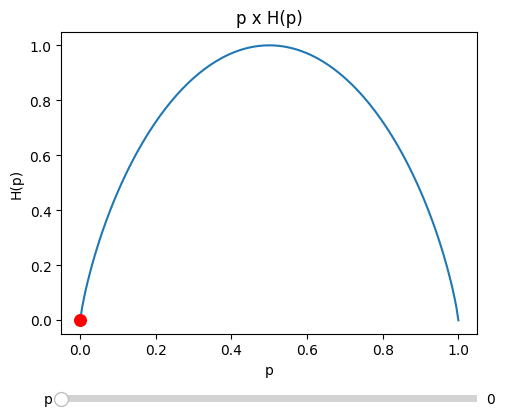

In [ ]:
_ = plot_entropy()

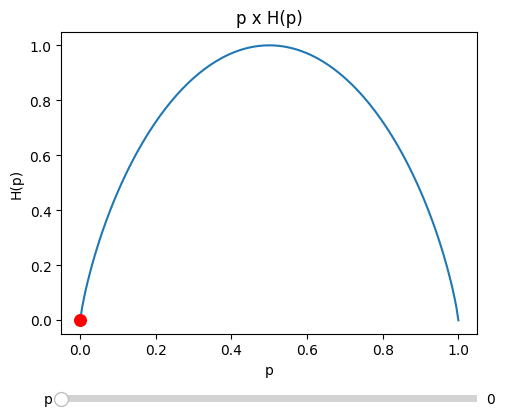

In [ ]:
# %matplotlib widget
_ = plot_entropy()

In [ ]:
X_train = np.array([[1, 1, 1],
[0, 0, 1],
 [0, 1, 0],
 [1, 0, 1],
 [1, 1, 1],
 [1, 1, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 1, 0],
 [0, 1, 0]])

y_train = np.array([1, 1, 0, 0, 1, 1, 0, 1, 0, 0])

In [ ]:
X_train[0]

array([1, 1, 1])

In [ ]:
def entropy(p):
    if p == 0 or p == 1:
        return 0
    else:
        return -p * np.log2(p) - (1- p)*np.log2(1 - p)

print(entropy(0.5))

1.0


In [ ]:
def split_indices(X, index_feature):
    """Given a dataset and a index feature, return two lists for the two split nodes, the left node has the animals that have
    that feature = 1 and the right node those that have the feature = 0
    index feature = 0 => ear shape
    index feature = 1 => face shape
    index feature = 2 => whiskers
    """
    left_indices = []
    right_indices = []
    for i,x in enumerate(X):
        if x[index_feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)
    return left_indices, right_indices

In [ ]:
split_indices(X_train, 0)

([0, 3, 4, 5, 7], [1, 2, 6, 8, 9])

In [ ]:
def weighted_entropy(X,y,left_indices,right_indices):
    """
    This function takes the splitted dataset, the indices we chose to split and returns the weighted entropy.
    """
    w_left = len(left_indices)/len(X)
    w_right = len(right_indices)/len(X)
    p_left = sum(y[left_indices])/len(left_indices)
    p_right = sum(y[right_indices])/len(right_indices)

    weighted_entropy = w_left * entropy(p_left) + w_right * entropy(p_right)
    return weighted_entropy

In [ ]:
left_indices, right_indices = split_indices(X_train, 0)
weighted_entropy(X_train, y_train, left_indices, right_indices)

0.7219280948873623

In [ ]:
def information_gain(X, y, left_indices, right_indices):
    """
    Here, X has the elements in the node and y is theirs respectives classes
    """
    p_node = sum(y)/len(y)
    h_node = entropy(p_node)
    w_entropy = weighted_entropy(X,y,left_indices,right_indices)
    return h_node - w_entropy

In [ ]:
information_gain(X_train, y_train, left_indices, right_indices)

0.2780719051126377

In [ ]:
for i, feature_name in enumerate(['Ear Shape', 'Face Shape', 'Whiskers']):
    left_indices, right_indices = split_indices(X_train, i)
    i_gain = information_gain(X_train, y_train, left_indices, right_indices)
    print(f"Feature: {feature_name}, information gain if we split the root node using this feature: {i_gain:.2f}")

Feature: Ear Shape, information gain if we split the root node using this feature: 0.28
Feature: Face Shape, information gain if we split the root node using this feature: 0.03
Feature: Whiskers, information gain if we split the root node using this feature: 0.12


 Depth 0, Root: Split on feature: 0
 - Left leaf node with indices [0, 3, 4, 5, 7]
 - Right leaf node with indices [1, 2, 6, 8, 9]


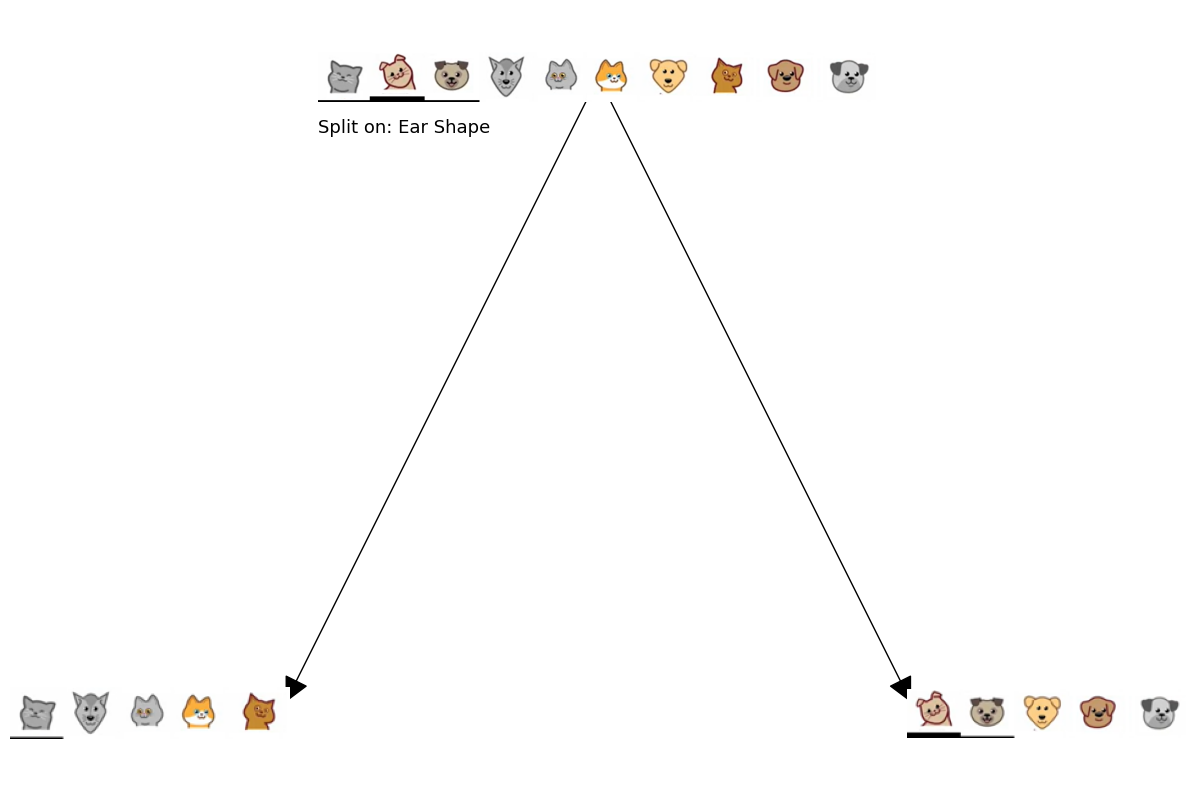

In [ ]:
tree = []
build_tree_recursive(X_train, y_train, [0,1,2,3,4,5,6,7,8,9], "Root", max_depth=1, current_depth=0, tree = tree)
generate_tree_viz([0,1,2,3,4,5,6,7,8,9], y_train, tree)

 Depth 0, Root: Split on feature: 0
- Depth 1, Left: Split on feature: 1
  -- Left leaf node with indices [0, 4, 5, 7]
  -- Right leaf node with indices [3]
- Depth 1, Right: Split on feature: 2
  -- Left leaf node with indices [1]
  -- Right leaf node with indices [2, 6, 8, 9]


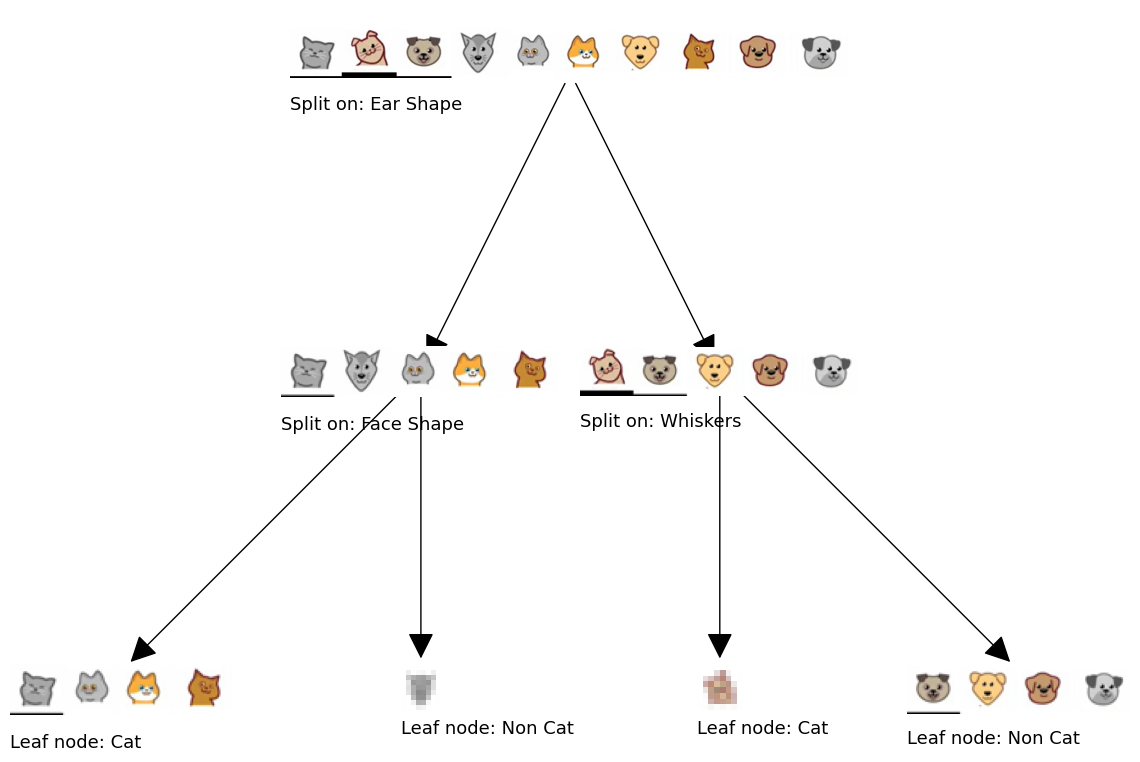

In [ ]:
tree = []
build_tree_recursive(X_train, y_train, [0,1,2,3,4,5,6,7,8,9], "Root", max_depth=2, current_depth=0, tree = tree)
generate_tree_viz([0,1,2,3,4,5,6,7,8,9], y_train, tree)